In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
MODEL_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_STATE = 32

regularization: a technique the penalizes meomorization that prevents models from over-learning, thereupon helping the model generalize the underlying patterns that would also be able to give proper predictions for unseen examples or samples
- dropout: removes nodes randomly during learning
- L1/L2 regularization: adds a cost to the loss function to prevent weights from getting too large
- data augmentation: modified versions of same data


drop regularization:
- prevents single node from learning too much
- forces the model to have distributed representations
- makes the model less reliant on individual or a small set of nodes and therefore stablizies the model


binary classification: for a given input the output is a binary value of 0 or1, True of False, A or B where a given object is of either one or the  other type
multiclass classification: for a given input the output belongs to one of the n number of classess (outputs)
multilabel classification: for a given input the output can have one or more labels to which an output based on respective input belongs to

image classification:
- inputs: numerically encoded values or representation of images (represented by width, height, color_channel)
- output: 1 or 0, A or B for binary classification; probability values (with respective  name or representation of the output that exists in the class labels)

general architecture of a classification:
- input layer shape (in_features): same as number of features
- hidden layer(s): problem specific, could range from a minimum of 1 to unlimited
- neurons per layer: problem specific, generally ranges from 4 to 512
- output layer: 1 for binary classification, 1 per class in multiclass classification
- hidden layer activation: generally ReLU
output activation: sigmoid for binary classification, softmax for multiclass classification
- loss function: binary crossentropy for binary classification, crossentropy for multiclass classification
- optimizer: sgd or adam


In [ ]:
# sample data for classification
import sklearn
from sklearn.datasets import make_circles

# 1000 samples
N_SAMPLES = 1000

# create circles
# two features of X per sample of y, y has two classess: 0 or 1
X, y = make_circles(N_SAMPLES,
                                  noise = 0.02,
                                  random_state=RANDOM_STATE)

len(X), len(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1000, 2), y shape: (1000,)


In [ ]:
# first five samples of X and y
print(f"first 5 samples of X: {X[:5]}")
print(f"first 5 samples of y: {y[:5]}")

first 5 samples of X: [[-0.07181058  0.76939682]
 [-0.53372693  0.54559515]
 [-0.41203154 -0.69069969]
 [-0.64995161  0.70280822]
 [-0.46282177 -0.67386285]]
first 5 samples of y: [1 1 1 0 1]


In [ ]:
# dataframe with pandas
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                                        "X2": X[:, 1],
                                        "y": y})
circles.head(10)

,X1,X2,y
0,-0.071811,0.769397,1
1,-0.533727,0.545595,1
2,-0.412032,-0.690700,1
3,-0.649952,0.702808,0
4,-0.462822,-0.673863,1
5,-0.391581,0.717798,1
6,-0.016587,-0.966336,0
7,-0.698380,-0.362622,1
8,0.360554,-0.956888,0
9,0.253533,0.741539,1


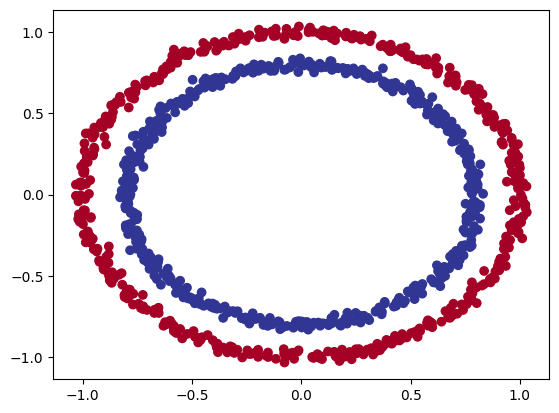

In [ ]:
# visualize circles data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
                 y=X[:, 1],
                  c=y, cmap=plt.cm.RdYlBu)

In [ ]:
from sklearn.model_selection import train_test_split

# turn datasets into tensors
#X_tensor = torch.from_numpy(X).type(torch.float).to(device=MODEL_DEVICE)
#y_tensor = torch.from_numpy(y).type(torch.float).to(device=MODEL_DEVICE)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.8, random_state=RANDOM_STATE)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: torch.Size([800, 2]), y_train shape: torch.Size([800])


In [ ]:
class BinClassificationModel(nn.Module):
    def __init__(self):
        super(BinClassificationModel, self).__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu((self.layer_1(x)))
        x = self.layer_2(x)
        return x


In [ ]:
#bin_model_0 = BinClassificationModel().to(device=MODEL_DEVICE)

In [ ]:
bin_model_01 = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
).to(MODEL_DEVICE)

In [ ]:
criterion = nn.BCEWithLogitsLoss() #loss function of BCE that comes along with sigmoid
optimizer = optim.Adam(params=bin_model_01.parameters(), lr=0.01) #optimizer

num_epochs = 100
X_train, X_test = X_train.to(MODEL_DEVICE), X_test.to(MODEL_DEVICE)
y_train, y_test = y_train.to(MODEL_DEVICE), y_test.to(MODEL_DEVICE)

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy measurement

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc


model outputs (logits) -> prediction probabilities -> prediction labels

In [ ]:
torch.manual_seed(RANDOM_STATE)
# train model
for epoch in range(num_epochs):
    bin_model_01.train()
    optimizer.zero_grad()

    y_logits = bin_model_01(X_train).squeeze()
    loss = criterion(y_logits, y_train)

    y_train_preds =torch.round(torch.sigmoid(y_logits))
    train_accuracy = accuracy_fn(y_train, y_train_preds)

    loss.backward()
    optimizer.step()

    bin_model_01.eval()
    with torch.inference_mode():
        test_logits = bin_model_01(X_test).squeeze()

        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = criterion(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
        print(f'epoch: {epoch} | train_loss: {loss:.4f} | train_acc: {train_accuracy:.4f} | test_loss: {test_loss:.4} | test_accuracy: {test_accuracy:.4f}"')

epoch: 0 | train_loss: 0.6954 | train_acc: 51.7500 | test_loss: 0.7025 | test_accuracy: 43.0000"
epoch: 10 | train_loss: 0.6888 | train_acc: 52.6250 | test_loss: 0.6943 | test_accuracy: 49.0000"
epoch: 20 | train_loss: 0.6728 | train_acc: 61.2500 | test_loss: 0.6723 | test_accuracy: 65.0000"
epoch: 30 | train_loss: 0.6180 | train_acc: 82.7500 | test_loss: 0.6173 | test_accuracy: 81.0000"
epoch: 40 | train_loss: 0.4923 | train_acc: 84.8750 | test_loss: 0.4892 | test_accuracy: 85.0000"
epoch: 50 | train_loss: 0.2940 | train_acc: 97.1250 | test_loss: 0.2996 | test_accuracy: 95.5000"
epoch: 60 | train_loss: 0.1244 | train_acc: 99.6250 | test_loss: 0.1247 | test_accuracy: 100.0000"
epoch: 70 | train_loss: 0.0349 | train_acc: 100.0000 | test_loss: 0.04019 | test_accuracy: 100.0000"
epoch: 80 | train_loss: 0.0104 | train_acc: 100.0000 | test_loss: 0.01461 | test_accuracy: 100.0000"
epoch: 90 | train_loss: 0.0051 | train_acc: 100.0000 | test_loss: 0.007556 | test_accuracy: 100.0000"


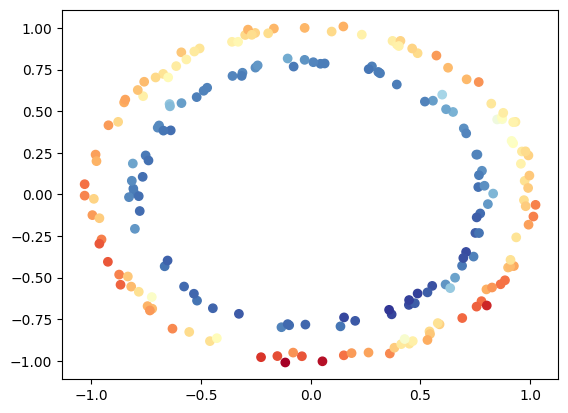

In [ ]:
trained_predictions = bin_model_01(X_test).squeeze().detach().cpu().numpy()

plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c= trained_predictions, cmap=plt.cm.RdYlBu)

In [ ]:
# import plot helper functions
import requests

from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper functions already exists")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper functions already exists


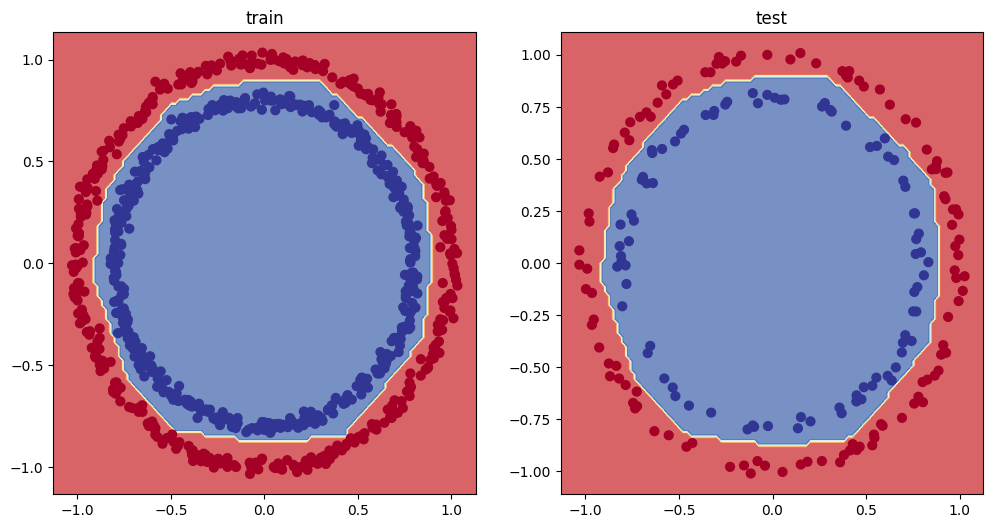

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(bin_model_01, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(bin_model_01, X_test, y_test)

plt.show()

In [ ]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X_raw = data.data         # shape: (n_samples, 30)
y_raw = data.target       # shape: (n_samples,)

X_bc_tensor = torch.tensor(X_raw, dtype=torch.float32)
y_bc_tensor = torch.tensor(y_raw, dtype=torch.float32)

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc_tensor, y_bc_tensor, test_size=0.2)

In [ ]:
model_bc_0 = nn.Sequential(
    nn.Linear(30, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)


In [ ]:
optimizer = optim.Adam(params=model_bc_0.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 1000

In [ ]:
torch.manual_seed(RANDOM_STATE)

for epoch in range(num_epochs):
    model_bc_0.train()
    optimizer.zero_grad()

    bc_train_logits = model_bc_0(X_train_bc).squeeze()
    loss = criterion(bc_train_logits, y_train_bc)

    y_train_bc_preds = torch.round(torch.sigmoid(bc_train_logits))
    bc_train_accuracy = accuracy_fn(y_train_bc, y_train_bc_preds)

    loss.backward()
    optimizer.step()

    model_bc_0.eval()
    with torch.inference_mode():
        test_logits_bc= model_bc_0(X_test_bc).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits_bc))

        test_loss_bc = criterion(y_test_bc, test_logits_bc)
        test_accuracy_bc = accuracy_fn(test_preds, y_test_bc)


    if epoch % 100 == 0:
        print(f'epoch: {epoch} | train_loss: {loss:.4f} | train_acc: {bc_train_accuracy:.4f} | test_loss: {test_loss_bc:.4} | test_accuracy: {test_accuracy_bc:.4f}"')

epoch: 0 | train_loss: 0.0001 | train_acc: 100.0000 | test_loss: -101.9 | test_accuracy: 71.9298"
epoch: 100 | train_loss: 0.0675 | train_acc: 96.7033 | test_loss: -9.128 | test_accuracy: 93.8596"
epoch: 200 | train_loss: 0.0289 | train_acc: 98.4615 | test_loss: -15.86 | test_accuracy: 93.8596"
epoch: 300 | train_loss: 0.0152 | train_acc: 99.3407 | test_loss: -21.49 | test_accuracy: 93.8596"
epoch: 400 | train_loss: 0.0067 | train_acc: 99.7802 | test_loss: -27.55 | test_accuracy: 93.8596"
epoch: 500 | train_loss: 0.0027 | train_acc: 100.0000 | test_loss: -29.2 | test_accuracy: 93.8596"
epoch: 600 | train_loss: 0.0008 | train_acc: 100.0000 | test_loss: -34.52 | test_accuracy: 93.8596"
epoch: 700 | train_loss: 0.0005 | train_acc: 100.0000 | test_loss: -36.35 | test_accuracy: 93.8596"
epoch: 800 | train_loss: 0.0004 | train_acc: 100.0000 | test_loss: -38.0 | test_accuracy: 93.8596"
epoch: 900 | train_loss: 0.0003 | train_acc: 100.0000 | test_loss: -39.3 | test_accuracy: 93.8596"


In [ ]:
with torch.inference_mode():
    bc_preds = torch.round(torch.sigmoid(model_bc_0(X_test_bc[:100]))).squeeze()

    print(bc_preds == y_test_bc[:100])
    print(accuracy_fn(y_test_bc[:100], bc_preds))

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True])
94.0
